In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_pacf
import pandas as pd
import random
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa import stattools as st
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import os
import math
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from tqdm import tqdm

In [2]:
def make_data(x, str,w):
    x=pd.DataFrame(x)
    window=w
    for i in range(1, window):
        column=f'{str}_lag{i}'
        x[column]=x[str].shift(i)
    return x

def make_label(x, w):
    window=w
    x['label_all']=x['label']
    for i in range(1, window):
        x.loc[(x['label_all']==1)|(x['label'].shift(i)==1), 'label_all']=1
        x.loc[(x['label_all']==0)&(x['label'].shift(i)==0), 'label_all']=0
    
    x['label']=x['label_all']
    return x[['label']]

def calc_leq(df, unit):
    df.reset_index(inplace=True, drop=True)
    for i in range(int(len(df)/unit)+1):
        hour_df=df.loc[i*unit:(i+1)*unit, 'original'].copy()
        N=len(hour_df)
        Leq=10*np.log10(np.sum(np.power(10, hour_df/10)))-10*np.log10(N)
        df.loc[i*unit:(i+1)*unit, 'leq']=Leq
    return df

def leq_filter(df):
    df=calc_leq(df, 18000)
    df.loc[(df['original']<df['leq']), 'd']=0
    return df

def validate(test_v, anorm, thr):
    test_v['z']=np.where(anorm>=thr, 1, 0)
    test_v.reset_index(inplace=True, drop=True)
    
    #     適合率
    tp=test_v[(test_v['label']==1)&(test_v['z']==1)]
    z_p=test_v[test_v['z']==1]
    pre_score=len(tp)/len(z_p)

    #     再現率
    df_anorm=[]
    search= 1 if test_v.loc[0, 'label']==0 else 0
    for num in range(len(test_v)):
        if search==1 and test_v.loc[num, 'label']==search:
            start=num
            search=0
        elif search==0 and test_v.loc[num, 'label']==search:
            stop=num-1
            anorm_range=test_v.loc[start:stop].copy()
            df_anorm.append(anorm_range)
            search=1
            
    count=[]
    for i in range(len(df_anorm)):
        if len(df_anorm[i].loc[df_anorm[i]['z']==1])>=1:
               count.append(i)    

    re_score=len(count)/len(df_anorm)

    return pre_score, re_score

def figure(df_test, anorm, d, thr):
    df_test['z']=np.where(d>=thr, 1, 0)
    
    z=df_test['z'].values*100
    test_plot=df_test['original'].values
    num_ax=math.ceil(len(test_plot)/17999)
    label=df_test['label'].values*100
    label_index=range(len(label))
    time_unit=60
    time=[t*0.2/60 for t in range(len(anorm))]
    plt.rcParams["font.size"] = 30

    fig, ax=plt.subplots(num_ax, 1, figsize=(35, 15*num_ax))
    for i in range(num_ax):
        ax[i].plot(time, anorm, '-r',linewidth = 1 )
        ax[i].plot(time, test_plot, '-k',linewidth = 2)
        ax[i].fill_between(time, label, facecolor='lime' )
        ax[i].fill_between(time, z, facecolor='coral' )
        ax[i].set_ylim(0, 90)
        ax[i].set_xlim(i*time_unit, time_unit*(i+1))
        ax[i].set_xticks(np.arange(60*i, 60*(i+1)))
        ax[i].xaxis.set_tick_params(rotation=70)
    plt.show()

def fig_pr(test_v, d, bins):
    bins_1=int(bins*0.8)
    thr_1=np.linspace(d.min(), 0.6, bins_1)
    thr_2=np.linspace(0.6, d.max(), bins-bins_1)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)
    f_score=(2*precision*recall)/(precision+recall)
    thr=thresholds[np.argmax(f_score)]

    plt.rcParams["font.size"] = 10
    plt.plot(recall, precision, marker='o', markevery=[np.argmax(f_score)], label='PR curve (AUC = %.2f)'%auc)
    plt.legend()
    plt.title('PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

    return precision, recall, f_score, thresholds, thr, auc

def fig_th_f(thresholds, f_score):
    plt.plot(thresholds, f_score, marker="o", markevery=[np.argmax(f_score)])
    plt.xlabel('thresholds')
    plt.ylabel('f_score')
    plt.grid(True)
    plt.show()
    
    return thresholds[np.argmax(f_score)], f_score.max()

In [3]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

,original,label,time,day
0,53.4,0,15,0
1,52.8,0,15,0
2,52.8,0,15,0
3,53.2,0,15,0
4,53.6,0,15,0
...,...,...,...,...
3995345,45.9,0,5,9
3995346,45.6,0,5,9
3995347,45.8,0,5,9
3995348,45.7,0,5,9


## ホールドアウト法
### 訓練、検証、テストへ分割
* 検証（チューニング用）：0日目
* テスト（最終評価用）：1 日目
* 訓練（学習用）：2, 3, 4, 5, 6, 7, 8, 9 日目

In [4]:
valid_day=[0]
test_day=[1]
train_day=[2, 3, 4, 5, 6, 7, 8, 9]

test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
valid_df=df[(df['day'].isin(valid_day))].reset_index(drop=True)
train_df=df[(df['day'].isin(train_day))].reset_index(drop=True)
train_df

,original,label,time,day
0,45.4,0,7,2
1,45.6,0,7,2
2,45.4,0,7,2
3,45.2,0,7,2
4,45.5,0,7,2
...,...,...,...,...
3275875,45.9,0,5,9
3275876,45.6,0,5,9
3275877,45.8,0,5,9
3275878,45.7,0,5,9


## グリッドサーチ
### チューニング

In [5]:
print(f'訓練データ(学習用)：{train_day}日目')
print(f'検証データ（チューニング用）：{valid_day}日目')

window_list=[11]
n_estimators_list=[240]
features_list=['sqrt']
max_depth=[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

best_score=0

for w in tqdm(window_list):
    df_list=[]
    for i in train_day:
        lag=[] 
        window=w
        lag.append(make_data(train_df.loc[train_df['day']==i, ['original']], 'original', window))
        lag.append(train_df.loc[train_df['day']==i, ['day']])
#         lag.append(make_label(train_df.loc[train_df['day']==i, ['label']], window))
        lag.append(train_df.loc[train_df['day']==i, ['label']])
        df_add_lag=pd.concat(lag, axis=1)
        df_list.append(df_add_lag)
    train=pd.concat(df_list)
    train=train.dropna().reset_index(drop=True)
    
    df_list=[]
    for i in valid_day:
        lag=[] 
        window=w
        lag.append(make_data(valid_df.loc[valid_df['day']==i, ['original']], 'original', window))
        lag.append(valid_df.loc[valid_df['day']==i, ['day']])
#         lag.append(make_label(valid_df.loc[valid_df['day']==i, ['label']], window))
        lag.append(valid_df.loc[valid_df['day']==i, ['label']])
        df_add_lag=pd.concat(lag, axis=1)
        df_list.append(df_add_lag)
    valid=pd.concat(df_list)
    valid=valid.dropna().reset_index(drop=True)
    
    #特徴量とラベルに分割
    X_train=train.loc[train['label']==0, train.columns[1:-2]].values
    X_valid=valid.loc[valid['label']==0, valid.columns[1:-2]].values
    
    y_train=train.loc[train['label']==0, train.columns[0]].values
    y_valid=valid.loc[valid['label']==0, valid.columns[0]].values
    
    for n in n_estimators_list:
        for f in features_list:
            for depth in max_depth:
                r_forest = RandomForestRegressor(n_estimators=n,
                                                 max_features=f,
                                                 max_depth=depth,
                                                 criterion='squared_error',
                                                 random_state=1,
                                                 n_jobs=-1)
                r_forest.fit(X_train, y_train)
                z_valid = r_forest.predict(X_valid)
                score=r2_score(y_valid, z_valid)  
                if score>best_score:
                    best_score=score
                    best_params={'window':w, 
                                'n_estimators':n, 
                                'max_features':f, 
                                'max_depth':depth}
                    print(f'更新R^2：{best_score}')
                    
print('==================================================================')
print(f'R^2最高：{best_score}')
print(f'パラメータ：{best_params}')

訓練データ(学習用)：[2, 3, 4, 5, 6, 7, 8, 9]日目
検証データ（チューニング用）：[0]日目


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

更新R^2：0.9914108972019884
更新R^2：0.9914148010626944


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [30:31<00:00, 1831.91s/it]

R^2最高：0.9914148010626944
パラメータ：{'window': 11, 'n_estimators': 240, 'max_features': 'sqrt', 'max_depth': 20}


# チューニング結果(学習データだけでなく、検証データも正常データのみを抜き出して評価する)
* window_list=[2, 5, 8, 10, 15, 20, 25, 30, 35]
* n_estimators_list=[3, 5, 10, 20, 30, 50, 100, 150, 180, 210, 240]
* features_list=['sqrt', 'log2', None]
* max_depth=[3, 5, 8, 10, 30, 40, 45, 50, 55, None]

## →best_params={'window': 10, 'n_estimators': 240, 'max_features': 'sqrt', 'max_depth': 30}
## best_R^2=0.9913312298816697
=============================================================  
* window_list=[9, 10, 11, 12, 13, 14]
* n_estimators_list=[240]
* features_list=['sqrt']
* max_depth=[11, 18, 25, 30, 35, 39]

## →best_params={'window': 11, 'n_estimators': 240, 'max_features': 'sqrt', 'max_depth': 25}
## best_R^2=0.9914056594262822

=============================================================  
* window_list=[11]
* n_estimators_list=[240]
* features_list=['sqrt']
* max_depth=[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

## →best_params={'window': 11, 'n_estimators': 240, 'max_features': 'sqrt', 'max_depth': 20}
## best_R^2=0.9914148010626944

## =========最終結果==========
## best_params={'window': 11, 'n_estimators': 240, 'max_features': 'sqrt', 'max_depth': 20}
# --------------------------------------------------------------------------

# チューニング結果(検証データは異常データも含む)
* window_list=[5, 8, 10, 15, 20, 25]
* n_estimators_list=[10, 20, 30, 50, 100, 150]
* features_list=['sqrt', 'log2','auto', None]
* max_depth=[3, 5, 8, 10, 30, None]

## →best_params={'window':25, 'n_estimators':150, 'max_features':'sqrt', 'max_depth':30}
=============================================================  
* window_list=[25, 30, 35, 40]
* n_estimators_list=[150, 165, 180, 200]
* features_list=['sqrt']
* max_depth=[30, 35, 40, 45]
## →best_params={'window': 30, 'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 40}
## →best_R^2=0.9869964389102168
=============================================================  
* window_list=[26, 27, 28, 29, 30, 31, 32, 33, 34]
* n_estimators_list=[200, 210, 220, 230, 240, 250]
* features_list=['sqrt']
* max_depth=[36, 37, 38, 39 40, 41, 42, 43, 44]
## →best_params={'window': 26, 'n_estimators': 220, 'max_features': 'sqrt', 'max_depth': 44}
## →best_R^2=0.9873136675226558
=============================================================  
* window_list=[26]
* n_estimators_list=[211, 215, 220, 225, 229]
* features_list=['sqrt']
* max_depth=[44]
## →best_params={'window': 26, 'n_estimators': 220, 'max_features': 'sqrt', 'max_depth': 44}
## →best_R^2=0.9873136675226558
=============================================================  
* window_list=[26]
* n_estimators_list=[216, 217, 218, 219, 220, 221, 222, 223, 224]
* features_list=['sqrt']
* max_depth=[44]
## →best_params={'window': 26, 'n_estimators': 222, 'max_features': 'sqrt', 'max_depth': 44}
## →best_R^2=0.9873144746757594

## =========最終結果==========
## best_params={'window': 26, 'n_estimators': 222, 'max_features': 'sqrt', 'max_depth': 44}
# ---------------------------------------------------------------------------------

## 最終評価

In [9]:
# best_params={'window':26, 
#             'n_estimators':222, 
#             'max_features':'sqrt', 
#             'max_depth':44}

In [11]:
# test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)

# #チューニング時に分割されていた訓練データと検証データをまとめて学習用のデータとする
# train_df=df[(df['day'].isin(valid_day))|(df['day'].isin(train_day))].reset_index(drop=True)
# train_day=np.sort(train_df['day'].unique()).tolist()

In [11]:
print(f'訓練データ（学習用）：{train_day}日目')
print(f'テストデータ（最終評価用）：{test_day}日目')

window=best_params['window']
df_list=[]
for i in train_day:
    lag=[] 
    lag.append(make_data(train_df.loc[train_df['day']==i, ['original']], 'original', window))
    lag.append(train_df.loc[train_df['day']==i, ['day']])
#     lag.append(make_label(train_df.loc[train_df['day']==i, ['label']], window))
    lag.append(train_df.loc[train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
train=pd.concat(df_list)
train=train.dropna().reset_index(drop=True)

df_list=[]
for i in test_day:
    lag=[] 
    lag.append(make_data(test_df.loc[test_df['day']==i, ['original']], 'original', window))
    lag.append(test_df.loc[test_df['day']==i, ['day']])
#     lag.append(make_label(test_df.loc[test_df['day']==i, ['label']], window))
    lag.append(test_df.loc[test_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
test=pd.concat(df_list)
test=test.dropna().reset_index(drop=True)

#特徴量とラベルに分割
X_train=train.loc[train['label']==0, train.columns[1:-2]].values
X_test=test[test.columns[1:-2]].values

y_train=train.loc[train['label']==0, train.columns[0]].values
y_test=test[test.columns[0]].values

r_forest = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                 max_features=best_params['max_features'],
                                 max_depth=best_params['max_depth'],
                                 criterion='squared_error',
                                 random_state=1,
                                 n_jobs=-1)
r_forest.fit(X_train, y_train)
z_test = r_forest.predict(X_test)
d=(z_test-y_test)**2

test_v=test[['original', 'label']].copy().reset_index(drop=True)
test_v['d']=d

#道路交通騒音に埋もれている異常音は正常とする
test_v=leq_filter(test_v)
test_v['d']=test_v['d']/test_v['d'].max()
d=test_v['d'].values

訓練データ（学習用）：[2, 3, 4, 5, 6, 7, 8, 9]日目
テストデータ（最終評価用）：[1]日目


## PR曲線

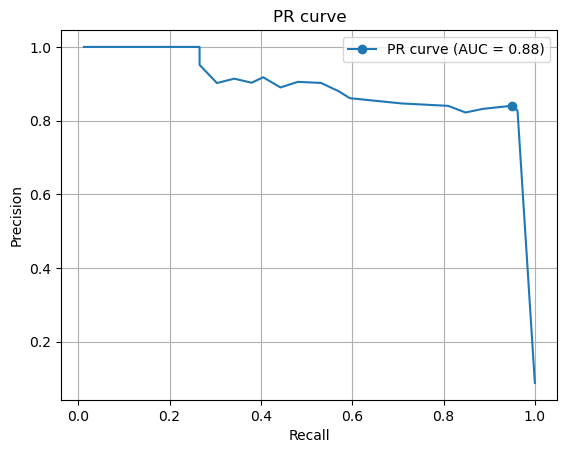

AUC：0.8768527381081593
理想の閾値：0.03870967741935484
F値（最高）：0.8914744904365294
適合率（最高）：0.8402366863905325
再現率（最高）：0.9493670886075949


In [12]:
thr_bins=40
p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d, thr_bins)
print('\033[31m'+f'AUC：{auc}'+'\033[0m')
print(f'理想の閾値：{thr}')
print(f'F値（最高）：{f_score.max()}')
print(f'適合率（最高）：{p_score[np.argmax(f_score)]}')
print(f'再現率（最高）：{r_score[np.argmax(f_score)]}')

## 異常度可視化

In [ ]:
p, r=validate(test_v, d, thr)
print(f'適合率：{p}')
print(f'再現率：{r}')

abnorm=(d*30)**2
figure(test_v, abnorm, d, thr)